## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sn

C:\Program Files\Python36\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [56]:
import pandas as pd

In [2]:
!pip install opencv-python

## Загружаем исходные данные

In [4]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
del train
del test

In [7]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

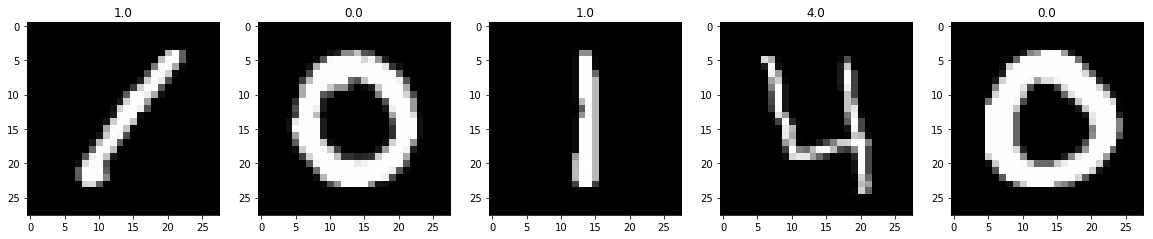

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [9]:
SZ=28

for i, img in enumerate(train_img):
    m=cv2.moments(img)
    skew = m['mu11']/m['mu02']
    #print ("skew: " + str(skew))
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img2 = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    train_img[i]=img2
    m2=cv2.moments(img2)
    skew2 = m2['mu11']/m2['mu02']
    #print ("skew2: " + str(skew2))

In [10]:
for i, img in enumerate(train_img):
    blur = cv2.GaussianBlur(img,(3,3),0)
    train_img[i]=blur

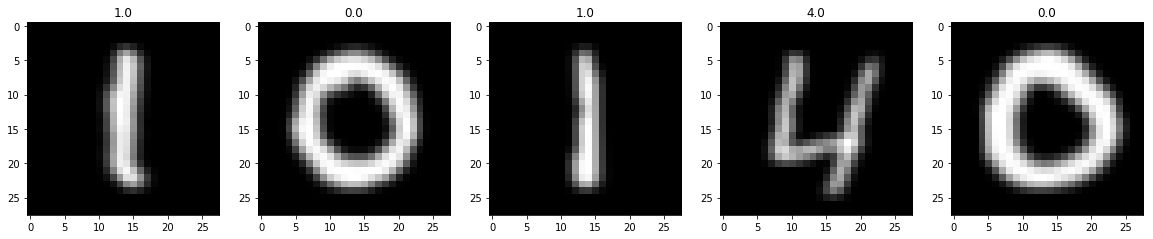

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5]):
    subplot = fig.add_subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i]);

In [12]:
SZ=28

for i, img in enumerate(test_img):
    m=cv2.moments(img)
    skew = m['mu11']/m['mu02']
    #print ("skew: " + str(skew))
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img2 = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    test_img[i]=img2
    m2=cv2.moments(img2)
    skew2 = m2['mu11']/m2['mu02']
    #print ("skew2: " + str(skew2))

In [13]:
for i, img in enumerate(test_img):
    blur = cv2.GaussianBlur(img,(3,3),0)
    test_img[i]=blur

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [26]:
def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)

In [40]:
train_img_flatten=train_img.reshape(42000,-1)

In [52]:
test_img_flatten=test_img.reshape(28000,-1)

In [43]:
clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))


for i, n_components in enumerate(n_components_array):
    pca = PCA(n_components=n_components)
    pca.fit(train_img_flatten)
    transform = pca.transform(train_img_flatten)
    score_array[i] = evaluate_classifier(clf, transform, train_label.tolist(), 0.8)
    

C:\Program Files\Python36\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


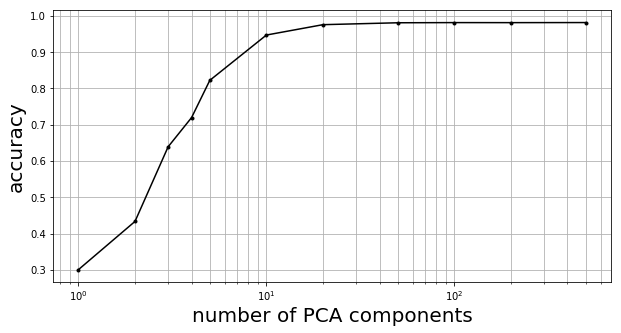

In [49]:
plt.figure(figsize=(10,5))
plt.plot(n_components_array,score_array,'k.-')
plt.xscale('log')
plt.xlabel("number of PCA components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")

In [54]:
pca = PCA(n_components=50)
pca.fit(train_img_flatten)
transform_train = pca.transform(train_img_flatten)
transform_test = pca.transform(test_img_flatten)

clf = KNeighborsClassifier()
clf.fit(transform_train,train_label)
train_predictions=clf.predict(transform_train)
results=clf.predict(transform_test)


NameError: name 'test' is not defined

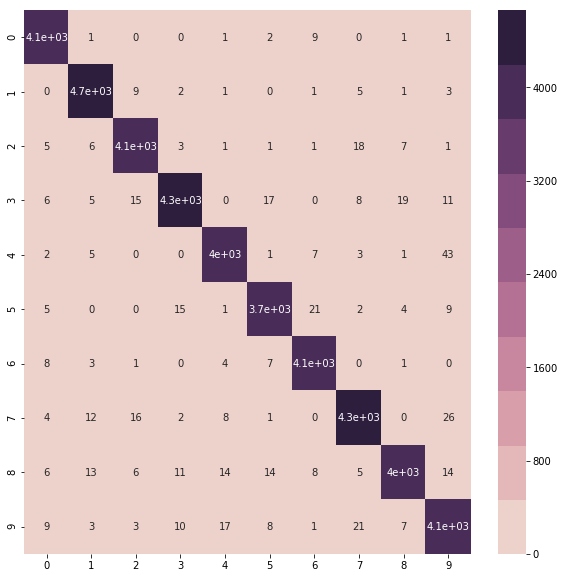

In [63]:
conf_array = confusion_matrix(train_label, train_predictions)
conf_df = pd.DataFrame(conf_array, index = range(10), columns = range(10))
plt.figure(figsize = (10, 10))
sn.heatmap(conf_df, annot=True, cmap=sn.cubehelix_palette(10))

In [64]:
np.savetxt('results.csv', 
           np.c_[range(1,len(transform_test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

# Kaggle score 0.98228

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [65]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [66]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [67]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [68]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [72]:
train_g_flatten =train_g.reshape(42000,-1) 
test_g_flatten =test_g.reshape(28000,-1) 

In [73]:
for i, n_components in enumerate(n_components_array):
    pca = PCA(n_components=n_components)
    pca.fit(train_g_flatten)
    transform = pca.transform(train_g_flatten)
    score_array[i] = evaluate_classifier(clf, transform, train_label, 0.8)

C:\Program Files\Python36\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


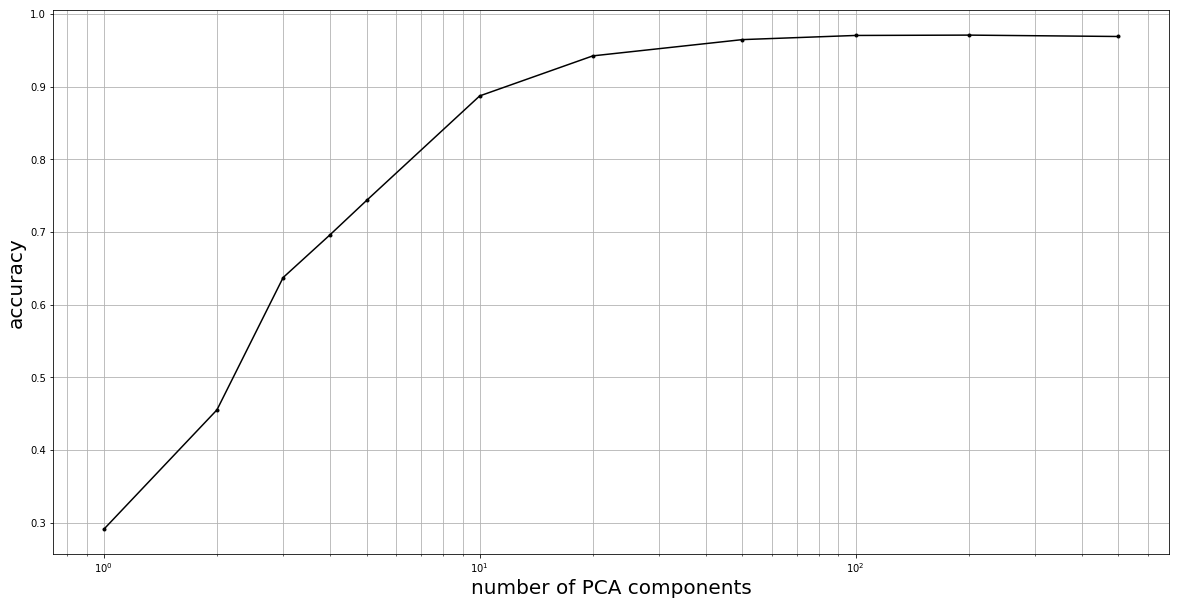

In [75]:
plt.figure(figsize=(20,10))
plt.plot(n_components_array,score_array,'k.-')
plt.xscale('log')
plt.xlabel("number of PCA components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")

In [76]:
pca = PCA(n_components=100)
pca.fit(train_g_flatten)
transform_train = pca.transform(train_g_flatten)
transform_test = pca.transform(test_g_flatten)

clf = KNeighborsClassifier()
clf.fit(transform_train,train_label)
train_predictions=clf.predict(transform_train)
results=clf.predict(transform_test)

In [77]:
np.savetxt('results.csv', 
           np.c_[range(1,len(transform_test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

# Kaggle score 0.96914